In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt



In [5]:
#데이터처리 : 결측치 처리, 오버샘플링 , 레이블 인코딩
df = pd.read_csv("C:/Users/User/oneDrive/장현서/dataset.csv")
df['bmi'] = df['bmi'].fillna(df['bmi'].mean())
df['smoking_status'] = df['smoking_status'].fillna('Unknown')

positive = df[df['stroke'] == 1]
negative = df[df['stroke'] == 0]
oversampled = positive.sample(len(negative), replace=True, random_state=42)
df_balanced = pd.concat([negative, oversampled])

X = df_balanced.drop('stroke', axis=1)
y = df_balanced['stroke']

categorical_cols = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
for col in categorical_cols:
    X[col] = LabelEncoder().fit_transform(X[col].astype(str))

#데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
#데이터 정규화
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)



In [17]:
#hyperparameter tuning
param_grid = {
    'hidden_layer_sizes': [(40, 20, 10), (100, 50, 25, 10)],
    'solver': ['adam'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive']
}

grid = GridSearchCV(
    MLPClassifier(max_iter=1000, random_state=42),
    param_grid,
    scoring='f1',
    cv=5,
    verbose=2
)
grid.fit(X_train, y_train)

best_params = grid.best_params_
print("Best Params from Tuning:", best_params)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END alpha=0.0001, hidden_layer_sizes=(40, 20, 10), learning_rate=constant, solver=adam; total time=  31.0s
[CV] END alpha=0.0001, hidden_layer_sizes=(40, 20, 10), learning_rate=constant, solver=adam; total time=  29.6s
[CV] END alpha=0.0001, hidden_layer_sizes=(40, 20, 10), learning_rate=constant, solver=adam; total time=  22.0s
[CV] END alpha=0.0001, hidden_layer_sizes=(40, 20, 10), learning_rate=constant, solver=adam; total time=  46.2s
[CV] END alpha=0.0001, hidden_layer_sizes=(40, 20, 10), learning_rate=constant, solver=adam; total time=  32.7s
[CV] END alpha=0.0001, hidden_layer_sizes=(40, 20, 10), learning_rate=adaptive, solver=adam; total time=  31.3s
[CV] END alpha=0.0001, hidden_layer_sizes=(40, 20, 10), learning_rate=adaptive, solver=adam; total time=  26.3s
[CV] END alpha=0.0001, hidden_layer_sizes=(40, 20, 10), learning_rate=adaptive, solver=adam; total time=  21.9s
[CV] END alpha=0.0001, hidden_layer_sizes=(

In [7]:
#튜닝결과값으로 mlp 학습
mlp_final = MLPClassifier(**best_params, max_iter=1000, random_state=42)
mlp_final.fit(X_train, y_train)

MLPClassifier(alpha=0.01, hidden_layer_sizes=(100, 50, 25, 10), max_iter=1000,
              random_state=42)

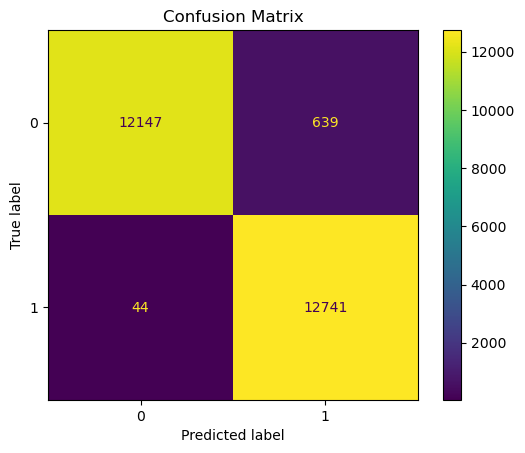

In [ ]:
#검사 및 confusioin matrix
y_pred = mlp_final.predict(X_test)
y_score = mlp_final.predict_proba(X_test)[:, 1]

cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()
plt.title("Confusion Matrix")
plt.show()

AUC-ROC: 0.988031853866369


<Figure size 640x480 with 0 Axes>

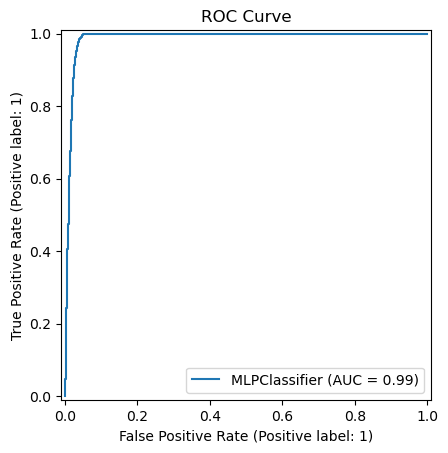

AUC-PR: 0.9787133935024267


<Figure size 640x480 with 0 Axes>

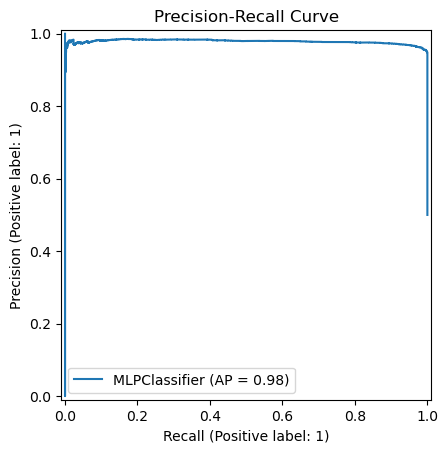

In [16]:
from sklearn.metrics import roc_curve, RocCurveDisplay, PrecisionRecallDisplay, average_precision_score
#Roc curve & AUROC
fpr, tpr, thresholds = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
print("AUC-ROC:", roc_auc) 
plt.figure()
RocCurveDisplay.from_estimator(mlp_final, X_test, y_test)
plt.title("ROC Curve")
plt.show()


#Precision-Recall curve & AUCPR
plt.figure()
precision, recall, _ = precision_recall_curve(y_test, y_score)
pr_auc = average_precision_score(y_test, y_score)
print("AUC-PR:", pr_auc)
PrecisionRecallDisplay.from_estimator(mlp_final, X_test, y_test)
plt.title("Precision-Recall Curve")
plt.show()




In [13]:
#F1 score
from sklearn.metrics import f1_score
f1 = f1_score(y_test, y_pred)
print("F1 Score:", f1)

F1 Score: 0.9738964265239825
